In [2]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import yfinance as yf
from scipy.stats import kurtosis, skew

class SPYDataAnalyzer:
    def __init__(self, years=10, cache_file='spy_data.csv'):
        self.years = years
        self.cache_file = cache_file
        self.data = None
    
    def fetch_data(self):
        # Check if data is cached and is up-to-date
        if os.path.exists(self.cache_file):
            modified_time = datetime.fromtimestamp(os.path.getmtime(self.cache_file))
            if datetime.now() - modified_time < timedelta(days=1):
                self.data = pd.read_csv(self.cache_file, parse_dates=['Date'], index_col='Date')
                return

        # Fetch data from Yahoo Finance
        end_date = datetime.now()
        start_date = end_date - timedelta(days=self.years * 365)
        spy = yf.download('SPY', start=start_date, end=end_date)
        self.data = spy[['Open', 'High', 'Low', 'Close']]
        self.data.to_csv(self.cache_file)
    
    def calculate_indicators(self):
        if self.data is None:
            raise ValueError("No data available. Please fetch data first.")
        
        # Calculate moving averages
        self.data['20_MA'] = self.data['Close'].rolling(window=20).mean()
        self.data['52_Week_MA'] = self.data['Close'].rolling(window=260).mean()
        
        # Calculate Bollinger Bands for 20-day and 52-week
        self.data['20_Upper_BB'] = self.data['20_MA'] + 2 * self.data['Close'].rolling(window=20).std()
        self.data['20_Lower_BB'] = self.data['20_MA'] - 2 * self.data['Close'].rolling(window=20).std()
        self.data['52_Upper_BB'] = self.data['52_Week_MA'] + 2 * self.data['Close'].rolling(window=260).std()
        self.data['52_Lower_BB'] = self.data['52_Week_MA'] - 2 * self.data['Close'].rolling(window=260).std()
        
        # Calculate daily returns and other statistics
        self.data['Daily_Return'] = self.data['Close'].pct_change()
        self.data['Cumulative_Return'] = (1 + self.data['Daily_Return']).cumprod() - 1
        self.data['Std_Dev'] = self.data['Daily_Return'].rolling(window=20).std()
        
        # Calculate statistical metrics only where there are enough data points
        self.data['Skewness'] = self.data['Daily_Return'].rolling(window=20).apply(lambda x: skew(x.dropna()), raw=False)
        self.data['Kurtosis'] = self.data['Daily_Return'].rolling(window=20).apply(lambda x: kurtosis(x.dropna()), raw=False)
        self.data['Positive_Return_Percentage'] = self.data['Daily_Return'].rolling(window=20).apply(lambda x: (x > 0).mean() * 100, raw=False)
        
        # Calculate Kelly ratio and fraction based on available returns
        win_rate = self.data['Positive_Return_Percentage'] / 100
        loss_rate = 1 - win_rate
        avg_win = self.data[self.data['Daily_Return'] > 0]['Daily_Return'].mean()
        avg_loss = abs(self.data[self.data['Daily_Return'] <= 0]['Daily_Return'].mean())
        self.data['Kelly_Ratio'] = win_rate - (loss_rate / (avg_win / avg_loss))
        self.data['Kelly_Fraction'] = self.data['Kelly_Ratio'] / 2
        
        # Drop initial rows with NaN values after calculations
        self.data.dropna(inplace=True)

    def get_data(self):
        return self.data
    
    def save_to_csv(self, filename='spy_analyzed_data.csv'):
        if self.data is not None:
            self.data.to_csv(filename)
        else:
            raise ValueError("No data available to save. Please fetch and process data first.")

# Example usage
analyzer = SPYDataAnalyzer(years=10)
analyzer.fetch_data()
analyzer.calculate_indicators()
data = analyzer.get_data()
print(data.head())

[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_115971/2448322259.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['20_MA'] = self.data['Close'].rolling(window=20).mean()


                  Open        High         Low       Close       20_MA  \
Date                                                                     
2015-09-15  196.610001  198.990005  195.960007  198.460007  197.107501   
2015-09-16  198.820007  200.410004  198.410004  200.179993  196.617501   
2015-09-17  200.020004  202.889999  199.279999  199.729996  196.188000   
2015-09-18  195.710007  198.679993  194.960007  195.449997  195.762000   
2015-09-21  196.440002  197.679993  195.210007  196.460007  195.693501   

            52_Week_MA  20_Upper_BB  20_Lower_BB  52_Upper_BB  52_Lower_BB  \
Date                                                                         
2015-09-15  205.146346   208.108348   186.106654   217.392008   192.900685   
2015-09-16  205.146231   205.950810   187.284192   217.392080   192.900382   
2015-09-17  205.140923   203.904356   188.471645   217.394991   192.886856   
2015-09-18  205.121154   202.554888   188.969113   217.421201   192.821107   
2015-09-21  2

In [3]:
import yfinance as yf
import yoptions as yo

class OptionsDataFetcher:
    def __init__(self, ticker):
        self.ticker = ticker
        self.stock = yf.Ticker(ticker)
    
    def fetch_options_data(self, expiration_date, strikes):
        try:
            options_chain = self.stock.option_chain(expiration_date)
        except ValueError as e:
            print(f"Error fetching options data: {e}")
            available_expirations = self.stock.options
            print(f"Available expirations are: {available_expirations}")
            expiration_date = available_expirations[0]  # Use the first available expiration date
            options_chain = self.stock.option_chain(expiration_date)
        
        options_data = {}
        for strike in strikes:
            option_data = options_chain.puts[options_chain.puts['strike'] == strike]
            if not option_data.empty:
                options_data[strike] = option_data
            else:
                print(f"No data available for strike price {strike}")
        
        return options_data

    def display_options_data(self, options_data):
        for strike, data in options_data.items():
            print(f"Option at strike price {strike}:")
            print(data)
            print("\n")

class BullPutStrategy:
    def __init__(self, options_data, strikes):
        self.options_data = options_data
        self.strikes = strikes
    
    def calculate_net_premium(self):
        premiums = []
        for strike in self.strikes:
            if strike in self.options_data and not self.options_data[strike].empty:
                premiums.append(self.options_data[strike]['lastPrice'].values[0])
            else:
                print(f"No premium data available for strike price {strike}")
                premiums.append(0)
        
        if len(premiums) < 2:
            raise ValueError("Not enough valid premiums to calculate net premium.")
        
        net_premium = premiums[0] - sum(premiums[1:])
        return net_premium

class BullPutLadder(BullPutStrategy):
    def __init__(self, options_data, strikes):
        super().__init__(options_data, strikes)
import datetime

# Example usage
ticker = 'SPY'
today = datetime.date.today()
next_week = today + datetime.timedelta(days=7)
expiration_date = next_week.strftime('%Y-%m-%d')

# Fetch the current close price of SPY
spy = yf.Ticker(ticker)
current_close = spy.history(period='1d')['Close'].iloc[-1]

# Define the strike prices for the bull put ladder strategy closer to the current close
strikes = [round(current_close * 0.95), round(current_close * 0.90), round(current_close * 0.85)]

fetcher = OptionsDataFetcher(ticker)
options_data = fetcher.fetch_options_data(expiration_date, strikes)
fetcher.display_options_data(options_data)

bull_put_ladder = BullPutLadder(options_data, strikes)
try:
    net_premium = bull_put_ladder.calculate_net_premium()
    print(f"\nNet Premium Received/Paid for the Bull Put Ladder: {net_premium}")
except ValueError as e:
    print(f"Error calculating net premium: {e}")


Error fetching options data: Expiration `2024-09-08` cannot be found. Available expirations are: [2024-09-03, 2024-09-04, 2024-09-05, 2024-09-06, 2024-09-09, 2024-09-10, 2024-09-11, 2024-09-12, 2024-09-13, 2024-09-20, 2024-09-27, 2024-09-30, 2024-10-04, 2024-10-11, 2024-10-18, 2024-10-31, 2024-11-15, 2024-11-29, 2024-12-20, 2024-12-31, 2025-01-17, 2025-01-31, 2025-02-28, 2025-03-21, 2025-03-31, 2025-04-17, 2025-06-20, 2025-06-30, 2025-08-15, 2025-09-19, 2025-12-19, 2026-01-16, 2026-06-18, 2026-12-18]
Available expirations are: ('2024-09-03', '2024-09-04', '2024-09-05', '2024-09-06', '2024-09-09', '2024-09-10', '2024-09-11', '2024-09-12', '2024-09-13', '2024-09-20', '2024-09-27', '2024-09-30', '2024-10-04', '2024-10-11', '2024-10-18', '2024-10-31', '2024-11-15', '2024-11-29', '2024-12-20', '2024-12-31', '2025-01-17', '2025-01-31', '2025-02-28', '2025-03-21', '2025-03-31', '2025-04-17', '2025-06-20', '2025-06-30', '2025-08-15', '2025-09-19', '2025-12-19', '2026-01-16', '2026-06-18', '202

In [7]:
class BearCallSpread:
    def __init__(self, options_data, strikes):
        self.options_data = options_data
        self.strikes = strikes
    
    def calculate_net_premium(self):
        premiums = []
        for strike in self.strikes:
            if strike in self.options_data and not self.options_data[strike].empty:
                premiums.append(self.options_data[strike]['lastPrice'].values[0])
            else:
                print(f"No premium data available for strike price {strike}")
                premiums.append(0)
        
        if len(premiums) < 2:
            raise ValueError("Not enough valid premiums to calculate net premium.")
        
        net_premium = premiums[0] - sum(premiums[1:])
        return net_premium

class BearCallLadder(BearCallSpread):
    def __init__(self, options_data, strikes):
        super().__init__(options_data, strikes)

# Example usage for Bear Call Spread
ticker = 'SPY'
expiration_date = '2024-10-31'

# Define the strike prices for the bear call spread strategy
strikes = [555, 570]

fetcher = OptionsDataFetcher(ticker)
options_data = fetcher.fetch_options_data(expiration_date, strikes)
fetcher.display_options_data(options_data)

bear_call_spread = BearCallSpread(options_data, strikes)
try:
    net_premium = bear_call_spread.calculate_net_premium()
    print(f"\nNet Premium Received/Paid for the Bear Call Spread: {net_premium}")
except ValueError as e:
    print(f"Error calculating net premium: {e}")

# Example usage for Bear Call Ladder
# Define the strike prices for the bear call ladder strategy
strikes = [555, 570, 572]

fetcher = OptionsDataFetcher(ticker)
options_data = fetcher.fetch_options_data(expiration_date, strikes)
fetcher.display_options_data(options_data)

bear_call_ladder = BearCallLadder(options_data, strikes)
try:
    net_premium = bear_call_ladder.calculate_net_premium()
    print(f"\nNet Premium Received/Paid for the Bear Call Ladder: {net_premium}")
except ValueError as e:
    print(f"Error calculating net premium: {e}")


Option at strike price 555:
         contractSymbol             lastTradeDate  strike  lastPrice   bid  \
121  SPY241031P00555000 2024-08-30 19:59:38+00:00   555.0       7.41  7.58   

      ask  change  percentChange  volume  openInterest  impliedVolatility  \
121  7.64   -2.24     -23.212435   309.0          3919           0.125695   

     inTheMoney contractSize currency  
121       False      REGULAR      USD  


Option at strike price 570:
         contractSymbol             lastTradeDate  strike  lastPrice    bid  \
136  SPY241031P00570000 2024-08-30 20:02:44+00:00   570.0      12.85  12.78   

       ask  change  percentChange  volume  openInterest  impliedVolatility  \
136  13.42   -4.15     -24.411762    89.0           639           0.107614   

     inTheMoney contractSize currency  
136        True      REGULAR      USD  



Net Premium Received/Paid for the Bear Call Spread: -5.4399999999999995
Option at strike price 555:
         contractSymbol             lastTradeDate  

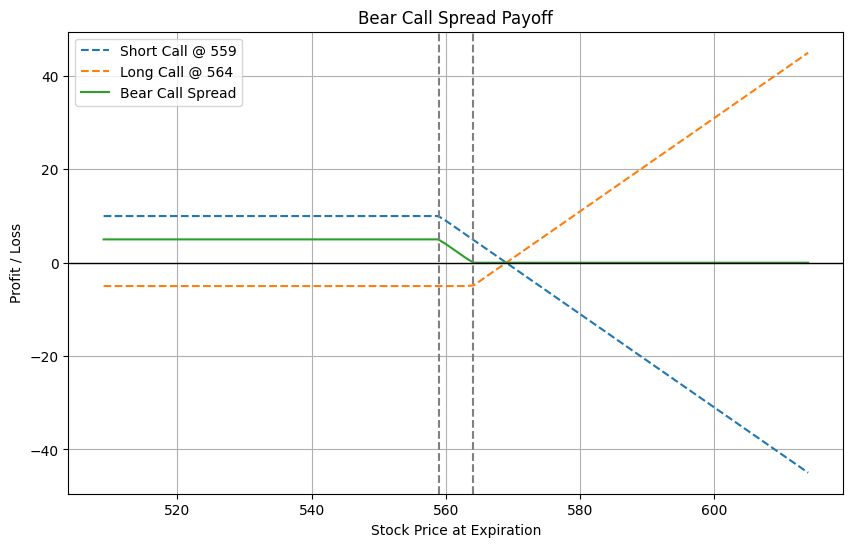

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_bear_call_spread(strikes, premiums):
    # Define the range of stock prices
    stock_prices = np.linspace(strikes[0] - 50, strikes[1] + 50, 100)
    
    # Calculate the payoff for each option
    payoff_short_call = premiums[0] - np.maximum(stock_prices - strikes[0], 0)
    payoff_long_call = np.maximum(stock_prices - strikes[1], 0) - premiums[1]
    
    # Calculate the total payoff for the bear call spread
    total_payoff = payoff_short_call + payoff_long_call
    
    # Plot the payoffs
    plt.figure(figsize=(10, 6))
    plt.plot(stock_prices, payoff_short_call, '--', label=f'Short Call @ {strikes[0]}')
    plt.plot(stock_prices, payoff_long_call, '--', label=f'Long Call @ {strikes[1]}')
    plt.plot(stock_prices, total_payoff, label='Bear Call Spread')
    plt.axhline(0, color='black', lw=1)
    plt.axvline(strikes[0], color='grey', linestyle='--')
    plt.axvline(strikes[1], color='grey', linestyle='--')
    plt.title('Bear Call Spread Payoff')
    plt.xlabel('Stock Price at Expiration')
    plt.ylabel('Profit / Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage for visualizing Bear Call Spread
strikes = [559, 564]  # Example strikes for the bear call spread
premiums = [10, 5]  # Example premiums for the options
visualize_bear_call_spread(strikes, premiums)


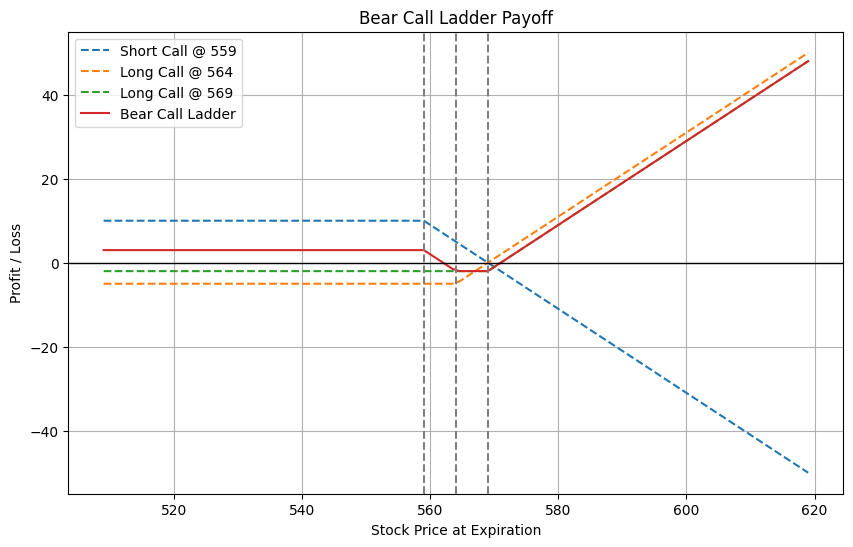

In [10]:
def visualize_bear_call_ladder(strikes, premiums):
    # Define the range of stock prices
    stock_prices = np.linspace(strikes[0] - 50, strikes[2] + 50, 100)
    
    # Calculate the payoff for each option
    payoff_short_call = premiums[0] - np.maximum(stock_prices - strikes[0], 0)
    payoff_long_call_1 = np.maximum(stock_prices - strikes[1], 0) - premiums[1]
    payoff_long_call_2 = np.maximum(stock_prices - strikes[2], 0) - premiums[2]
    
    # Calculate the total payoff for the bear call ladder
    total_payoff = payoff_short_call + payoff_long_call_1 + payoff_long_call_2
    
    # Plot the payoffs
    plt.figure(figsize=(10, 6))
    plt.plot(stock_prices, payoff_short_call, '--', label=f'Short Call @ {strikes[0]}')
    plt.plot(stock_prices, payoff_long_call_1, '--', label=f'Long Call @ {strikes[1]}')
    plt.plot(stock_prices, payoff_long_call_2, '--', label=f'Long Call @ {strikes[2]}')
    plt.plot(stock_prices, total_payoff, label='Bear Call Ladder')
    plt.axhline(0, color='black', lw=1)
    plt.axvline(strikes[0], color='grey', linestyle='--')
    plt.axvline(strikes[1], color='grey', linestyle='--')
    plt.axvline(strikes[2], color='grey', linestyle='--')
    plt.title('Bear Call Ladder Payoff')
    plt.xlabel('Stock Price at Expiration')
    plt.ylabel('Profit / Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage for visualizing Bear Call Ladder
strikes = [559, 564, 569]  # Example strikes for the bear call ladder
premiums = [10, 5, 2]  # Example premiums for the options
visualize_bear_call_ladder(strikes, premiums)
